# Aplicaciones de la simulación

Dada una secuencia de 6 números enteros y un séptimo valor (también entero) como objetivo, el problema consiste en obtener una secuencia de operadores aritméticos (+, −, ×, /) que, respetando el orden de los 6 valores dados, nos permita aproximarnos lo más posible al valor objetivo. Por ejemplo, dados los números: 25, 6, 9, 75, 50 y 3, las siguientes secuencias de operadores se interpretan como
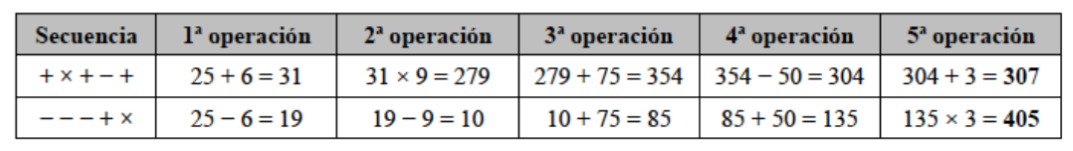

Si nuestro valor objetivo fuera el 307, la primera de las secuencias sería mejor solución que la segunda; de hecho, sería una solución óptima ya que se trata de la máxima aproximación posible. Dados los números 75, 3, 1, 4, 50, 6, 12, 8 obtener la secuencia de operadores que más aproximen el resultado de las operaciones correspondientes al valor 852.

In [186]:
import random
import numpy as np

current_seed = random.randint(0, 1000000)
random.seed(current_seed)
np.random.seed(current_seed)
print(f"Current random seed: {current_seed}") # 119,160

# Definición del problema: (Valores default)
lista_numeros = [ 75, 3, 1, 4, 50, 6, 12, 8] # ejemplo: [25, 6, 9, 75, 50, 3, 8]
objetivo = 852 # ejemplo: 307
operadores = ['+', '-', '*', '/']

Current random seed: 627875


In [187]:
import random
from random import randint
import numpy as np

def generar_poblacion(tam_poblacion):
    """
    Genera una población inicial de individuos 
    INPUT: tam_poblacion (int): Número de individuos en la población
    OUTPUT: Lista de listas donde cada sublista representa un individuo
    """   
    # Inicializamos la población
    poblacion = []
    
    # Generamos cada individuo
    for _ in range(tam_poblacion):
        # Creamos un individuo aleatorio con índices que representan operadores ('+', '-', '*', '/')
        individuo = [randint(0, len(operadores)-1) for _ in range(len(lista_numeros) - 1)]
        poblacion.append(individuo)
        
    return poblacion

In [188]:
def evaluar_individuo(operadores):
    """
    Aplica los operadores codificados por el individuo a la lista de numeros
    INPUT: operadores ([int]): Un individuo (Vector de operadores codificados del 0 al 3) .
    OUTPUT: Evaluacion del individuo
    
    (Devuelve None si hay una división por cero o resultado no válido.)
    """
    # Creamos un diccionario que mapea los operadores a sus funciones
    aplicar_operador = {
        0: lambda x, y: x + y,
        1: lambda x, y: x - y,
        2: lambda x, y: x * y,
        3: lambda x, y: x / y 
    }

    result = lista_numeros[0]
    for i, op in enumerate(operadores):
        try:
            result = aplicar_operador[op](result, lista_numeros[i + 1])
            if isinstance(result, complex) or result == float('inf'):
                return 10E9
        except ZeroDivisionError:
            return 10E9
    return abs(objetivo-result)

In [189]:
def evaluar_poblacion(poblacion):
    """
    Evalua una población dada 
    INPUT: poblacion ([[int]]): Vector de individuos.
    OUTPUT: Evaluaciones de cada individuo
    """ 
    # Inicializo vector de puntuaciones
    evaluaciones = []

    for i in poblacion:
        evaluaciones.append(evaluar_individuo(i))

    return evaluaciones

In [190]:
def individuo_to_string(ind):
    """
    Función para imprimir individuos
    """
    str = ""
    for _ in ind:
        str += "("
    for i in range(len(ind)+len(lista_numeros)):
        if i % 2 == 0:
            if i == 0:
                str += f"{lista_numeros[i//2]}"
            else:
                str += f"{lista_numeros[i//2]})"
        else:
            if ind[(i-1)//2] == 0:
                str += " + "
            elif ind[(i-1)//2] == 1:
                str += " - "
            elif ind[(i-1)//2] == 2:
                str += " * "
            elif ind[(i-1)//2] == 3:
                str += " / "
    
    return str + f" = {evaluar_individuo(ind):.0f}"


def print_poblacion(poblacion):
    """
    Función para imprimir poblaciones
    """
    evals = evaluar_poblacion(poblacion)
    mejor = evals.index(min(evals))
    print(f"Mejor Individuo [{mejor+1}] : {individuo_to_string(poblacion[mejor])}, score: {evals[mejor]:.2f}")
    print("=" * 100)
    for i in range(len(poblacion)):
        print(f"Individuo {i+1}: {poblacion[i]},    score: {objetivo} - {evaluar_individuo(poblacion[i]):.2f} = {evals[i]:.2f}")
    return

### Operadores (seleccion (prob y torneo), cruce y mutacion)

In [191]:
def seleccion_torneo(poblacion, k_torneo, num_seleccionados):
    """
    Realiza selección por torneo con selección única.
    
    INPUT:
    - poblacion: lista de individuos.
    - evaluaciones: lista de fitness o score.
    - k_torneo: tamaño del grupo de torneo.
    - num_seleccionados: número de individuos a seleccionar.
    
    OUTPUT:
    - lista de individuos seleccionados únicos.
    """
    seleccionados = []
    disponibles = list(range(len(poblacion)))  # Lista de índices disponibles
    evaluaciones = evaluar_poblacion(poblacion)
    
    for _ in range(num_seleccionados):
        # Selecciona k_torneo individuos al azar de los disponibles
        indices_torneo = random.sample(disponibles, min(k_torneo, len(disponibles)))
        participantes = [poblacion[i] for i in indices_torneo]
        evaluar_torneo = [evaluaciones[i] for i in indices_torneo]
        
        # Seleccionar al mejor del torneo
        mejor_indice_local = evaluar_torneo.index(min(evaluar_torneo))
        ganador_indice = indices_torneo[mejor_indice_local]
        ganador = poblacion[ganador_indice]
        
        # Eliminar el índice seleccionado de disponibles
        disponibles.remove(ganador_indice)
        seleccionados.append(ganador)
        
    return seleccionados

In [192]:
def seleccion_deterministica(poblacion, num_seleccionados):
    seleccionados = []
    evaluaciones = evaluar_poblacion(poblacion)
    # Create pairs of (individual, evaluation)
    poblacion_evaluada = list(zip(poblacion, evaluaciones))
    # Sort by evaluation (ascending order)
    poblacion_ordenada = sorted(poblacion_evaluada, key=lambda x: x[1])
    # Select the best k individuals
    seleccionados = [ind for ind, _ in poblacion_ordenada[:num_seleccionados]]
    
    return seleccionados    

In [193]:
def eliminar_peores(poblacion, n):
    """
    Elimina probabilísticamente los n individuos peor evaluados de la población.
    
    Args:
        poblacion (list): Lista de individuos en la población.
        n (int): Número de individuos a eliminar.
        
    Returns:
        list: Población después de eliminar los n individuos.
    """
    for _ in range(n):
        # Evaluar la población
        evals = evaluar_poblacion(poblacion)
        total_eval = sum(evals)
        
        # Calcular probabilidades inversas (peores evaluaciones tienen mayor probabilidad de eliminación)
        probs = [(total_eval - eval) / total_eval for eval in evals]
        
        # Seleccionar el índice del individuo a eliminar
        ind = random.choices(range(len(poblacion)), weights=probs, k=1)[0]
        
        # Eliminar al individuo seleccionado
        poblacion.pop(ind)
    
    return poblacion



In [194]:
pob_prueba = generar_poblacion(30)
evals = evaluar_poblacion(pob_prueba)
print(sorted(evals))
eliminar_peores(pob_prueba, 10)
print(sorted(evaluar_poblacion(pob_prueba)))
print(len(pob_prueba))

[58, 388, 459.5, 549.3333333333333, 580.0, 608, 677.28, 716.0, 718, 829.84, 834.56, 836.96, 843.9944444444444, 849.8541666666666, 851.23375, 854.01, 855.0933333333334, 855.28125, 871.04, 881.75, 920.16, 1388, 2472.0, 3316, 3994.0, 7737.0, 10662, 10768.0, 29596, 546444]
[58, 459.5, 549.3333333333333, 608, 716.0, 718, 829.84, 836.96, 854.01, 855.0933333333334, 855.28125, 871.04, 920.16, 1388, 2472.0, 3316, 3994.0, 7737.0, 10662, 546444]
20


In [195]:
def cruce_un_punto(padre1, padre2, prob_cruce=0.8):
    """
    Realiza un cruce de un punto entre dos individuos con una cierta probabilidad.
    INPUT:
    - padre1: primer individuo (lista de genes).
    - padre2: segundo individuo (lista de genes).
    - prob_cruce: probabilidad de realizar el cruce.
    OUTPUT:
    - hijo1, hijo2: nuevos individuos resultantes del cruce.
    """
    if random.random() < prob_cruce:
        punto_cruce = random.randint(1, len(padre1) - 1)
        hijo1 = padre1[:punto_cruce] + padre2[punto_cruce:]
        hijo2 = padre2[:punto_cruce] + padre1[punto_cruce:]
    else:
        # Si no hay cruce, los hijos son copias de los padres
        hijo1, hijo2 = padre1.copy(), padre2.copy()
    
    return hijo1, hijo2

In [196]:
def mutar(individuo, operadores, prob_mutacion=0.1):
    """
    Realiza una mutación aleatoria en un individuo con una cierta probabilidad.
    INPUT:
    - individuo: lista de genes.
    - operadores: rango de valores posibles para los genes.
    - prob_mutacion: probabilidad de mutar cada gen.
    OUTPUT:
    - individuo mutado.
    """
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:  # Mutación basada en probabilidad
            individuo[i] = random.choice([0, 1, 2, 3])
    return individuo

# Genetic Main

In [197]:
def genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=True):

    # Defino listas para las representaciones
    best_fitness_history = []
    average_fitness_history = [] 
    # CASO DE ERROR
    if (len(lista_numeros) < 2):
        print("Error: La lista debe tener al menos dos números.")
        return -1
    
    # Crear de población inicial
    poblacion = generar_poblacion(n_inicial)
    mejor_score = float('inf')
    mejor_solucion = None

    for _ in range (n_epocas):
        # Evaluamos la poblacion actual
        evaluaciones = evaluar_poblacion(poblacion)
        
        #registrar la mejor solucion hasta el momento
        min_score = min(evaluaciones)
        if min_score < mejor_score:
            mejor_score = min_score
            mejor_solucion = poblacion[evaluaciones.index(min_score)].copy()
        
        best_fitness_history.append(min_score)
        average_fitness_history.append(np.mean(evaluaciones))
        
        # Criterio de parada
        if mejor_score == 0:
            break
        
        # Seleccionamos padres y generamos siguiente población
        padres = seleccion_torneo(poblacion, k_torneo = k_torneo, num_seleccionados = n_inicial)

        nueva_poblacion = []
        tamaño_poblacion = n_inicial

        # Aplicar cruce y generar nueva población
        for i in range(0, len(padres), 2):
            if i + 1 < len(padres):  # Asegurar que hay suficientes padres para cruzar
                padre1, padre2 = padres[i], padres[i + 1]
                hijo1, hijo2 = cruce_un_punto(padre1, padre2, prob_cruce=prob_cruce)
                nueva_poblacion.extend([hijo1, hijo2]) ## ERROR
            else:
                print('no hay pareja')
                nueva_poblacion.append(padres[i])  # Si no hay pareja, el individuo sobrevive
                
        # Aplicar mutación a la nueva población
        nueva_poblacion = [mutar(individuo, operadores, prob_mutacion=prob_mutacion) for individuo in nueva_poblacion]
        poblacion = nueva_poblacion
                
                
                
    
    #imprimo solo la última población
    if see_last_pop: print_poblacion(poblacion)
    
    return mejor_solucion, mejor_score, best_fitness_history, average_fitness_history

In [198]:
def condicion_parada(max_epocas, iteraciones, best_fitness_history):
    
    if iteraciones >= max_epocas:
        return False

    #si el fitness es 0, entonces paramos la simulación
    if len(best_fitness_history) > 0:
        if best_fitness_history[-1] == 0:
            return False
        
    # si los últimos 20 fitness difieren en menos de 10E9, entonces paramos la simulación
    if len(best_fitness_history) > max_epocas/3:
        if abs(best_fitness_history[-1] - best_fitness_history[-int(max_epocas/3)]) < 10E-9 and abs(best_fitness_history[-1] - 1) < 10E-9*objetivo:
            return False
          
    return True

In [199]:
from typing import List, Tuple

def deterministic_genetic_main(
        lista_numeros: List[int], 
        objetivo: int,
        operadores: List[str],
        n_inicial: int,
        k_torneo: int,
        max_epocas: int,
        prob_cruce: float,
        prob_mutacion: float,
        see_last_pop: bool = True
    ) -> Tuple[List, float, List, List]:
    
    # inicializamos las listas que vamos a usar para guardar los datos
    best_fitness_history = []
    average_fitness_history = [] 
    mejor_score = 0
    mejor_individuo = None
    iter = 0
    MINIMUM_POPULATION_SIZE = 2
    REPLACEMENT_RATIO = 0.5
    n_reemplazos = int(n_inicial*REPLACEMENT_RATIO)
    

    # CASO DE ERROR
    if (len(lista_numeros) < MINIMUM_POPULATION_SIZE) or n_inicial <= 0:
        raise ValueError("Error: La lista debe tener al menos dos números.")
    # Add validation for probability values
    if not (0 <= prob_cruce <= 1) or not (0 <= prob_mutacion <= 1):
        raise ValueError("Probabilities must be between 0 and 1")
    
    # Seleccionar aleatoriamente la población inicial
    poblacion = generar_poblacion(n_inicial)
    
    evaluaciones = evaluar_poblacion(poblacion)  

    # Hasta que se cumpla la condición de parada
    while condicion_parada(max_epocas,iter, best_fitness_history):
        iter += 1

        # encontrar el mejor individuo de la población
        evaluaciones = evaluar_poblacion(poblacion)  
        
        mejor_score = min(evaluaciones)
        mejor_individuo = poblacion[evaluaciones.index(mejor_score)].copy()        
        
        best_fitness_history.append(mejor_score)
        average_fitness_history.append(np.mean(evaluaciones))

        # Seleccionar 2M buenos individuos de la población {y1,..., y2M}
        # padres = seleccion_deterministica(poblacion, 2*n_reemplazos)
        padres = seleccion_torneo(poblacion, k_torneo, 2*n_reemplazos)

        # Para k = 1,…,M cruzar los pares (y2k-1, y2k) obteniendo los pares {z2k-1, z2k}
        hijos = []
        for i in range(n_reemplazos):
            if i + 1 < len(padres):  # Asegurar que hay suficientes padres para cruzar
                padre1, padre2 = padres[i], padres[i + 1]
                hijo1, hijo2 = cruce_un_punto(padre1, padre2, prob_cruce=prob_cruce)
                hijos.extend([hijo1, hijo2]) 
        
        # Para k = 1,…,2M mutar zk obteniendo wk. Sea Mj = {w1,…,w2M}
        hijos = [mutar(hijo, operadores, prob_mutacion=prob_mutacion) for hijo in hijos]
        
        # Seleccionar 2M malos individuos de la población Vj = {v1,..., v2M}
        eliminar_peores(poblacion, 2*n_reemplazos)
    
        poblacion += hijos
        
                
    # imprimo información de la simulación: iteraciones, mejor resultado, crossover rate, mutación rate, etc.
    print(f"Iteraciones: {iter}, Mejor: {mejor_score}, Cruce: {prob_cruce}, Mutación: {prob_mutacion}")
    
    #imprimo solo la última población
    if see_last_pop: print_poblacion(poblacion)
    
    return mejor_individuo, mejor_score, best_fitness_history, average_fitness_history

In [200]:
# Definición del problema: (Valores default)
lista_numeros =[75, 3, 1, 4, 50, 6, 12, 8] # [ 75, 3, 1, 4, 50, 6, 12, 8] # ejemplo: [25, 6, 9, 75, 50, 3, 8]
objetivo = 852 # ejemplo: 307
operadores = ['+', '-', '*', '/']

In [201]:
n_inicial = 30
n_epocas = 500
k_torneo = 3
prob_cruce = 0.6
prob_mutacion = 0.05

mejor, _, best_fitness_history, average_fitness_history = deterministic_genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, 
                                                                   n_epocas, prob_cruce, prob_mutacion)
print("=" * 100)
print(f"{individuo_to_string(mejor)}, score: {evaluar_individuo(mejor)}")

Iteraciones: 5, Mejor: 0, Cruce: 0.6, Mutación: 0.05
Mejor Individuo [2] : (((((((75 * 3) + 1) * 4) - 50) - 6) + 12) - 8) = 0, score: 0.00
Individuo 1: [2, 2, 0, 1, 3, 0, 2],    score: 852 - 517.33 = 517.33
Individuo 2: [2, 0, 2, 1, 1, 0, 1],    score: 852 - 0.00 = 0.00
Individuo 3: [2, 0, 2, 1, 1, 1, 2],    score: 852 - 5836.00 = 5836.00
Individuo 4: [2, 2, 0, 1, 3, 0, 1],    score: 852 - 818.17 = 818.17
Individuo 5: [2, 2, 0, 1, 1, 1, 2],    score: 852 - 436.00 = 436.00
Individuo 6: [2, 3, 0, 1, 3, 1, 2],    score: 852 - 709.33 = 709.33
Individuo 7: [2, 3, 0, 1, 0, 2, 0],    score: 852 - 1376.00 = 1376.00
Individuo 8: [0, 2, 1, 1, 1, 1, 0],    score: 852 - 838.00 = 838.00
Individuo 9: [0, 2, 1, 1, 0, 2, 0],    score: 852 - 484.00 = 484.00
Individuo 10: [2, 3, 0, 1, 1, 0, 1],    score: 852 - 675.00 = 675.00
Individuo 11: [2, 3, 0, 1, 1, 0, 0],    score: 852 - 659.00 = 659.00
Individuo 12: [0, 2, 2, 1, 1, 1, 1],    score: 852 - 616.00 = 616.00
Individuo 13: [0, 2, 2, 1, 1, 0, 1],    sc

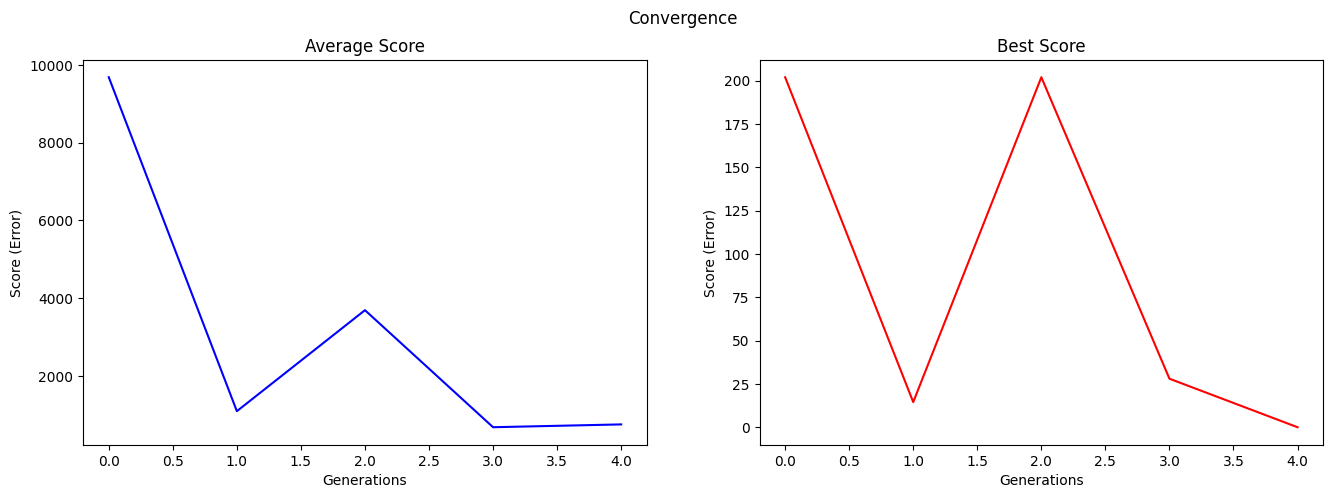

In [202]:
import matplotlib.pyplot as plt

generations_range = range(len(best_fitness_history))  # Rango de generaciones en el historial
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Error promedio
axs[0].plot(generations_range, average_fitness_history, color="blue")
axs[0].set_title("Average Score")
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Score (Error)")


# Error máximo (mejor fitness)
axs[1].plot(generations_range, best_fitness_history, color="red")
axs[1].set_title("Best Score")
axs[1].set_xlabel("Generations")
axs[1].set_ylabel("Score (Error)")

plt.suptitle(f"Convergence")
plt.show()

# Testing

Iteraciones: 466, Mejor: 1, Cruce: 0.6, Mutación: 0.05
Iteraciones: 167, Mejor: 1.0, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 10.04000000000002, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 15, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 5.666666666666629, Cruce: 0.6, Mutación: 0.05
Iteraciones: 184, Mejor: 1, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 40.75, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 5.666666666666629, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 10.04000000000002, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 3, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 0.20000000000004547, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 5.666666666666629, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 10.04000000000002, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 3.0, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 4.666666666666686, Cruce: 0.6, Mutación: 0.05
Iteraciones: 500, Mejor: 3.0, Cruce:

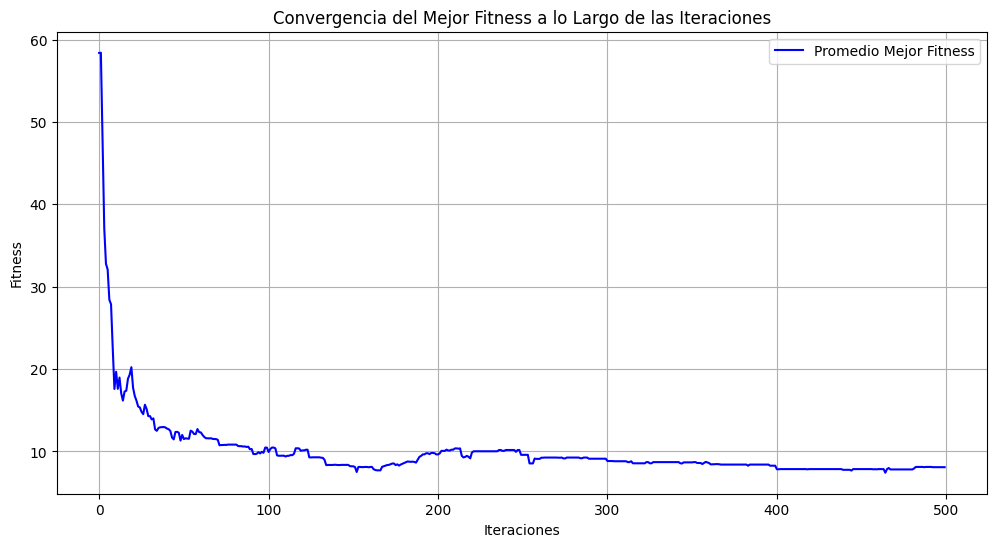

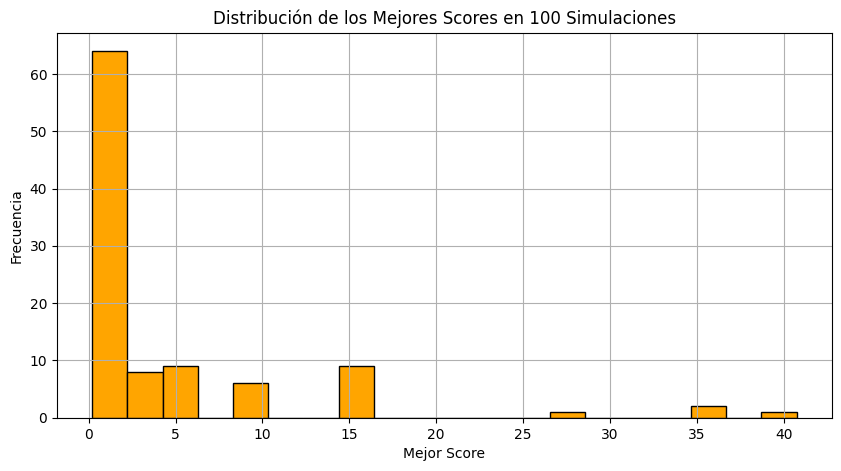

Media de mejor_score: 4.686700000000001
Cantidad de veces que se alcanza el óptimo (307): 0/100


In [203]:
import matplotlib.pyplot as plt
import statistics

# Parámetros
n_simulaciones = 100
n_inicial = 30
n_epocas = 500
k_torneo = 3
prob_cruce = 0.6
prob_mutacion = 0.05
objetivo = 307

# Lista para almacenar los mejores scores y las iteraciones
mejores_scores = []
optimos = 0  # Contador de veces que se alcanza el óptimo
scores_por_iteracion = []  # Historial de mejores scores por iteración

for _ in range(n_simulaciones):
    mejor, _, best_fitness_history, _ = deterministic_genetic_main(
        lista_numeros, objetivo, operadores, 
        n_inicial, k_torneo, 
        n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)
    
    # Evaluar el score del mejor individuo
    score = evaluar_individuo(mejor)
    mejores_scores.append(score)
    
    # Contar si el mejor score alcanza el óptimo
    if score == objetivo:
        optimos += 1
    
    # Guardar el historial del mejor fitness
    scores_por_iteracion.append(best_fitness_history)

# Calcular la media de los mejores scores
media_mejor_score = statistics.mean(mejores_scores)

# Preparar datos para visualización
# Promedio de fitness por iteración
average_fitness_per_iteration = [
    statistics.mean([iter_scores[i] for iter_scores in scores_por_iteracion if i < len(iter_scores)])
    for i in range(n_epocas)
]

# Gráficos
plt.figure(figsize=(12, 6))

# Promedio del mejor fitness por iteración
plt.plot(range(n_epocas), average_fitness_per_iteration, label="Promedio Mejor Fitness", color="blue")

# Títulos y etiquetas
plt.title("Convergencia del Mejor Fitness a lo Largo de las Iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Fitness")
plt.legend()
plt.grid()
plt.show()

# Histograma de los mejores scores
plt.figure(figsize=(10, 5))
plt.hist(mejores_scores, bins=20, color="orange", edgecolor="black")
plt.title("Distribución de los Mejores Scores en 100 Simulaciones")
plt.xlabel("Mejor Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

# Resultados en texto
print("=" * 50)
print(f"Media de mejor_score: {media_mejor_score}")
print(f"Cantidad de veces que se alcanza el óptimo ({objetivo}): {optimos}/{n_simulaciones}")


ANALISIS DE RESULTADOS

Iteraciones: 187, Mejor: 1, Cruce: 0.6, Mutación: 0.05
Iteraciones: 170, Mejor: 1, Cruce: 0.6, Mutación: 0.05
Iteraciones: 169, Mejor: 1, Cruce: 0.6, Mutación: 0.05
Iteraciones: 175, Mejor: 1, Cruce: 0.6, Mutación: 0.05


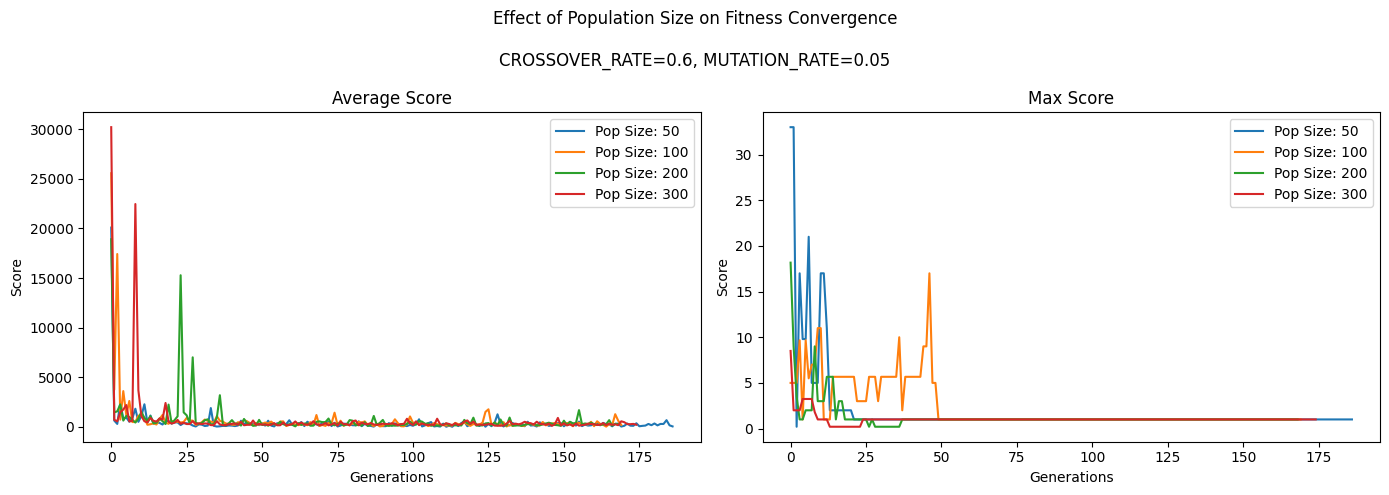

In [204]:
def poblacion_experiments():
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for n_inicial in population_sizes:
        
        # Ejecutar el solver y obtener los historiales de fitness
        _, _, best_fitness_history, average_fitness_history = deterministic_genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)

        # Rango de generaciones en el historial
        generations_range = range(len(best_fitness_history))

        # Gráfico del "Average Score" para cada tamaño de población
        axs[0].plot(generations_range, average_fitness_history, label=f"Pop Size: {n_inicial}")
        axs[0].set_title("Average Score")
        axs[0].set_xlabel("Generations")
        axs[0].set_ylabel("Score")

        # Gráfico del "Max Score" (mejor fitness) para cada tamaño de población
        axs[1].plot(generations_range, best_fitness_history, label=f"Pop Size: {n_inicial}")
        axs[1].set_title("Max Score")
        axs[1].set_xlabel("Generations")
        axs[1].set_ylabel("Score")

    # Ajustes finales de título y leyenda
    plt.suptitle(f"Effect of Population Size on Fitness Convergence\n\nCROSSOVER_RATE={prob_cruce}, MUTATION_RATE={prob_mutacion}")
    axs[0].legend(loc="upper right")
    axs[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Configuración de tamaños de población para evaluar
population_sizes = [50, 100, 200, 300]  # Diferentes tamaños de población inicial

# Ejecutar los experimentos
poblacion_experiments()

Iteraciones: 500, Mejor: 3.0, Cruce: 0.3, Mutación: 0.05
Iteraciones: 230, Mejor: 1, Cruce: 0.3, Mutación: 0.1
Iteraciones: 327, Mejor: 1, Cruce: 0.3, Mutación: 0.2
Iteraciones: 176, Mejor: 1, Cruce: 0.7, Mutación: 0.05
Iteraciones: 499, Mejor: 1, Cruce: 0.7, Mutación: 0.1
Iteraciones: 190, Mejor: 1, Cruce: 0.7, Mutación: 0.2
Iteraciones: 500, Mejor: 3.0, Cruce: 0.9, Mutación: 0.05
Iteraciones: 190, Mejor: 1, Cruce: 0.9, Mutación: 0.1
Iteraciones: 351, Mejor: 1.0, Cruce: 0.9, Mutación: 0.2


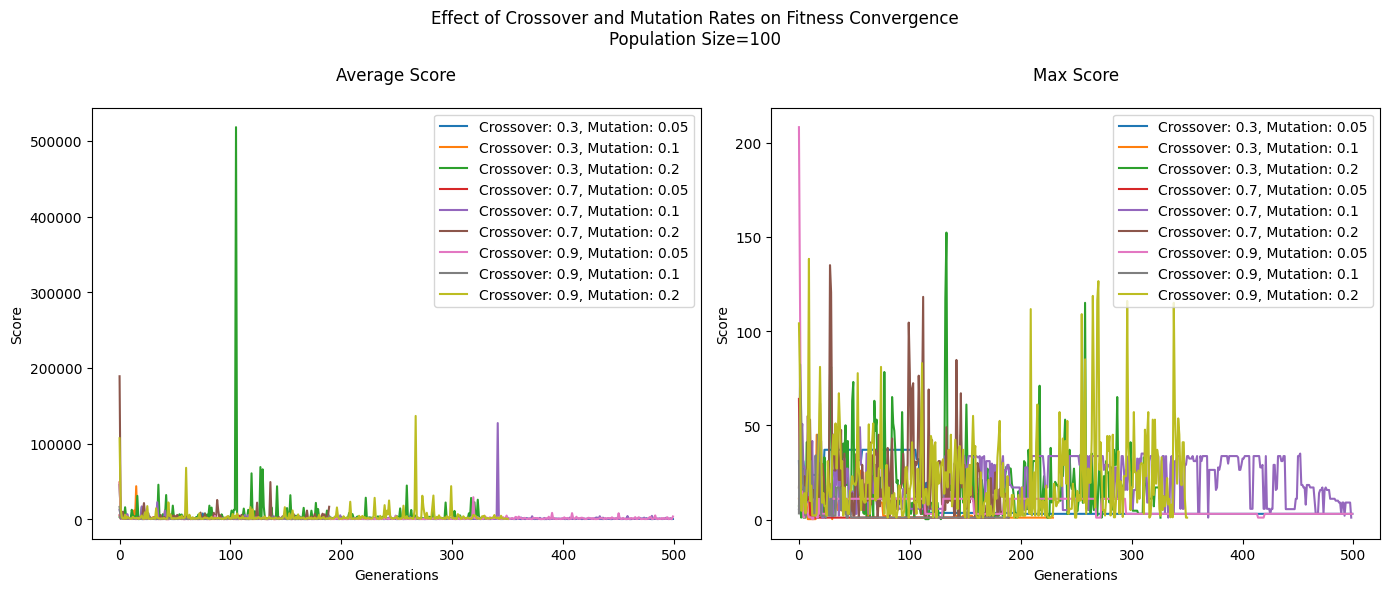

In [205]:
def run_crossover_mutation_experiments():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for prob_cruce in crossover_rates:
        for prob_mutacion in mutation_rates:

            # Ejecutar el solver y obtener los historiales de fitness
            _, _, best_fitness_history, average_fitness_history = deterministic_genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)

            # Rango de generaciones en el historial
            generations_range = range(len(best_fitness_history))

            # Gráfico del "Average Score" para cada combinación de cruce y mutación
            label = f"Crossover: {prob_cruce}, Mutation: {prob_mutacion}"
            axs[0].plot(generations_range, average_fitness_history, label=label)
            axs[0].set_title("Average Score", pad=20)
            axs[0].set_xlabel("Generations")
            axs[0].set_ylabel("Score")

            # Gráfico del "Max Score" (mejor fitness) para cada combinación de cruce y mutación
            axs[1].plot(generations_range, best_fitness_history, label=label)
            axs[1].set_title("Max Score", pad=20)
            axs[1].set_xlabel("Generations")
            axs[1].set_ylabel("Score")

    # Ajustes finales de título y leyenda
    plt.suptitle(f"Effect of Crossover and Mutation Rates on Fitness Convergence\nPopulation Size=100")
    axs[0].legend(loc="upper right")
    axs[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Configuración de tasas de cruce y mutación para evaluar
crossover_rates = [0.3, 0.7, 0.9]   # Diferentes tasas de cruce
mutation_rates = [0.05, 0.1, 0.2]   # Diferentes tasas de mutación

n_inicial = 50
k_torneo = 3

# Ejecutar los experimentos
run_crossover_mutation_experiments()

Iteraciones: 271, Mejor: 1, Cruce: 0.8, Mutación: 0.1
Iteraciones: 500, Mejor: 33.66666666666663, Cruce: 0.8, Mutación: 0.1
Iteraciones: 500, Mejor: 5.666666666666629, Cruce: 0.8, Mutación: 0.1
Iteraciones: 180, Mejor: 1, Cruce: 0.8, Mutación: 0.1


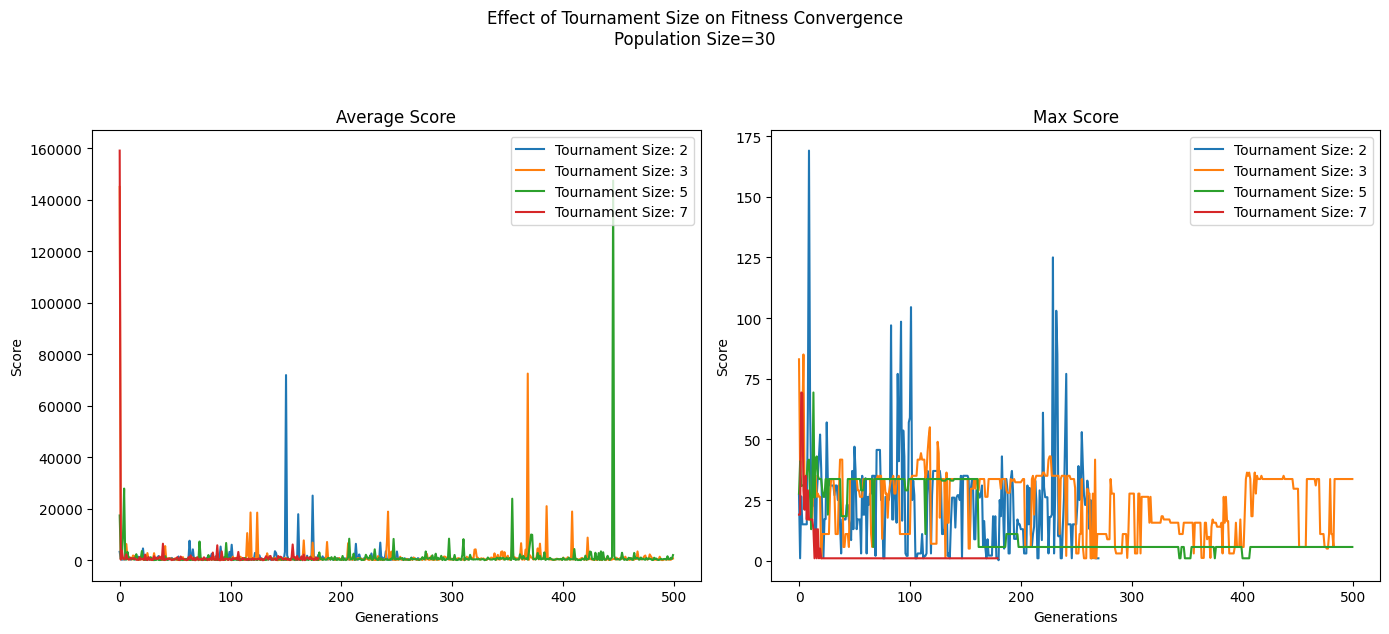

In [206]:
def run_tournament_experiments():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for k_torneo in tournament_sizes:
        
        # Ejecutar el solver y obtener los historiales de fitness
        _, _, best_fitness_history, average_fitness_history = deterministic_genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)

        # Rango de generaciones en el historial
        generations_range = range(len(best_fitness_history))

        # Gráfico del "Average Score" para cada tamaño de torneo
        label = f"Tournament Size: {k_torneo}"
        axs[0].plot(generations_range, average_fitness_history, label=label)
        axs[0].set_title("Average Score")
        axs[0].set_xlabel("Generations")
        axs[0].set_ylabel("Score")

        # Gráfico del "Max Score" (mejor fitness) para cada tamaño de torneo
        axs[1].plot(generations_range, best_fitness_history, label=label)
        axs[1].set_title("Max Score")
        axs[1].set_xlabel("Generations")
        axs[1].set_ylabel("Score")

    # Ajustes finales de título y leyenda
    plt.suptitle(f"Effect of Tournament Size on Fitness Convergence\nPopulation Size={n_inicial}", y=1.05)
    axs[0].legend(loc="upper right")
    axs[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Configuración de tamaños de torneo para evaluar
tournament_sizes = [2, 3, 5, 7]   # Diferentes tamaños de torneo para evaluación
n_inicial = 30
prob_cruce = 0.8
prob_mutacion = 0.1              

# Ejecutar los experimentos
run_tournament_experiments()